In [1]:
import argparse
import uproot
import glob
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [1]:
tree = "Delphes"
branches = ["Track.PID", "Track.PT", "Track.P", "Track.EtaOuter", "Track.PhiOuter", "Track.XOuter", "Track.YOuter"]
pionPID = 211 # plus/minus

In [2]:
def getDataFromRootFile(file):
    with uproot.open(file) as f:
        # load the branches
        temp = {}
        for branch in branches:
            temp[branch] = np.array(ak.flatten(f[tree][branch].array()))
        
        # selection
        cut = (abs(temp["Track.PID"])==pionPID)

        # apply selection (remove everything except pions)
        for branch in branches:
            temp[branch] = temp[branch][cut]
        
        # track properties
        # based on the image here https://github.com/kdp-lab/pixelav/blob/ppixelav2v2/ppixelav2_operating_inst.pdf
        #cota = 1./np.tan(temp["Track.Phi"]) # phi = alpha - pi -> cot(alpha) = cot(phi+pi) = cot(phi) = 1/tan(phi)
        #cotb = 1./np.tan(temp["Track.Eta"]) # should be theta but need to get get it # theta = beta - pi -> cot(beta) = cot(theta+pi) = cot(theta) = 1/tan(theta)
        tempalpha =temp["Track.Phi"] + np.pi
        alpha = tempalpha.tolist()
        tempbeta = temp["Track.Eta"] + np.pi
        beta = tempbeta.tolist()
        p = temp["Track.P"].tolist() # [GeV]
        #flp = np.zeros(p.shape) # Purpose????
        localx = temp["Track.XOuter"].tolist() # [mm]
        localy = temp["Track.YOuter"].tolist() # [mm]
        pT = temp["Track.PT"].tolist() # [GeV]
    return alpha, beta, p, localx, localy, pT

In [12]:
files = "/home/elizahoward/cmspix28-mc-sim/temp/"
file = uproot.open(files+"minbias_0.40_0.50_GeV.root")

In [11]:
for branch in file["Delphes"]:
    print(branch)
    print(branch.keys())

<TBranchElement 'Event' (20 subbranches) at 0x7f1e9fd74490>
['Event.fUniqueID', 'Event.fBits', 'Event.Number', 'Event.ReadTime', 'Event.ProcTime', 'Event.ProcessID', 'Event.MPI', 'Event.Weight', 'Event.CrossSection', 'Event.CrossSectionError', 'Event.Scale', 'Event.AlphaQED', 'Event.AlphaQCD', 'Event.ID1', 'Event.ID2', 'Event.X1', 'Event.X2', 'Event.ScalePDF', 'Event.PDF1', 'Event.PDF2']
<TBranch 'Event_size' at 0x7f1e9fd63fa0>
[]
<TBranchElement 'Weight' (3 subbranches) at 0x7f1e9fd667c0>
['Weight.fUniqueID', 'Weight.fBits', 'Weight.Weight']
<TBranch 'Weight_size' at 0x7f1e9fc5ba30>
[]
<TBranchElement 'Particle' (24 subbranches) at 0x7f1e9fc07220>
['Particle.fUniqueID', 'Particle.fBits', 'Particle.PID', 'Particle.Status', 'Particle.IsPU', 'Particle.M1', 'Particle.M2', 'Particle.D1', 'Particle.D2', 'Particle.Charge', 'Particle.Mass', 'Particle.E', 'Particle.Px', 'Particle.Py', 'Particle.Pz', 'Particle.P', 'Particle.PT', 'Particle.Eta', 'Particle.Phi', 'Particle.Rapidity', 'Particle.T',

In [3]:
# load the root files
delphes_track_pt = []
delphes_particle_pt = []

alpha = []
beta = []
p = []
localx = []
localy = []
pT = []

for f in os.listdir(files):
    if ".root" in f:
        tempalpha, tempbeta, tempp, templocalx, templocaly, temppT = getDataFromRootFile(files+f)
        alpha += tempalpha
        beta += tempbeta
        p += tempp
        localx += templocalx
        localy += templocaly
        pT += temppT

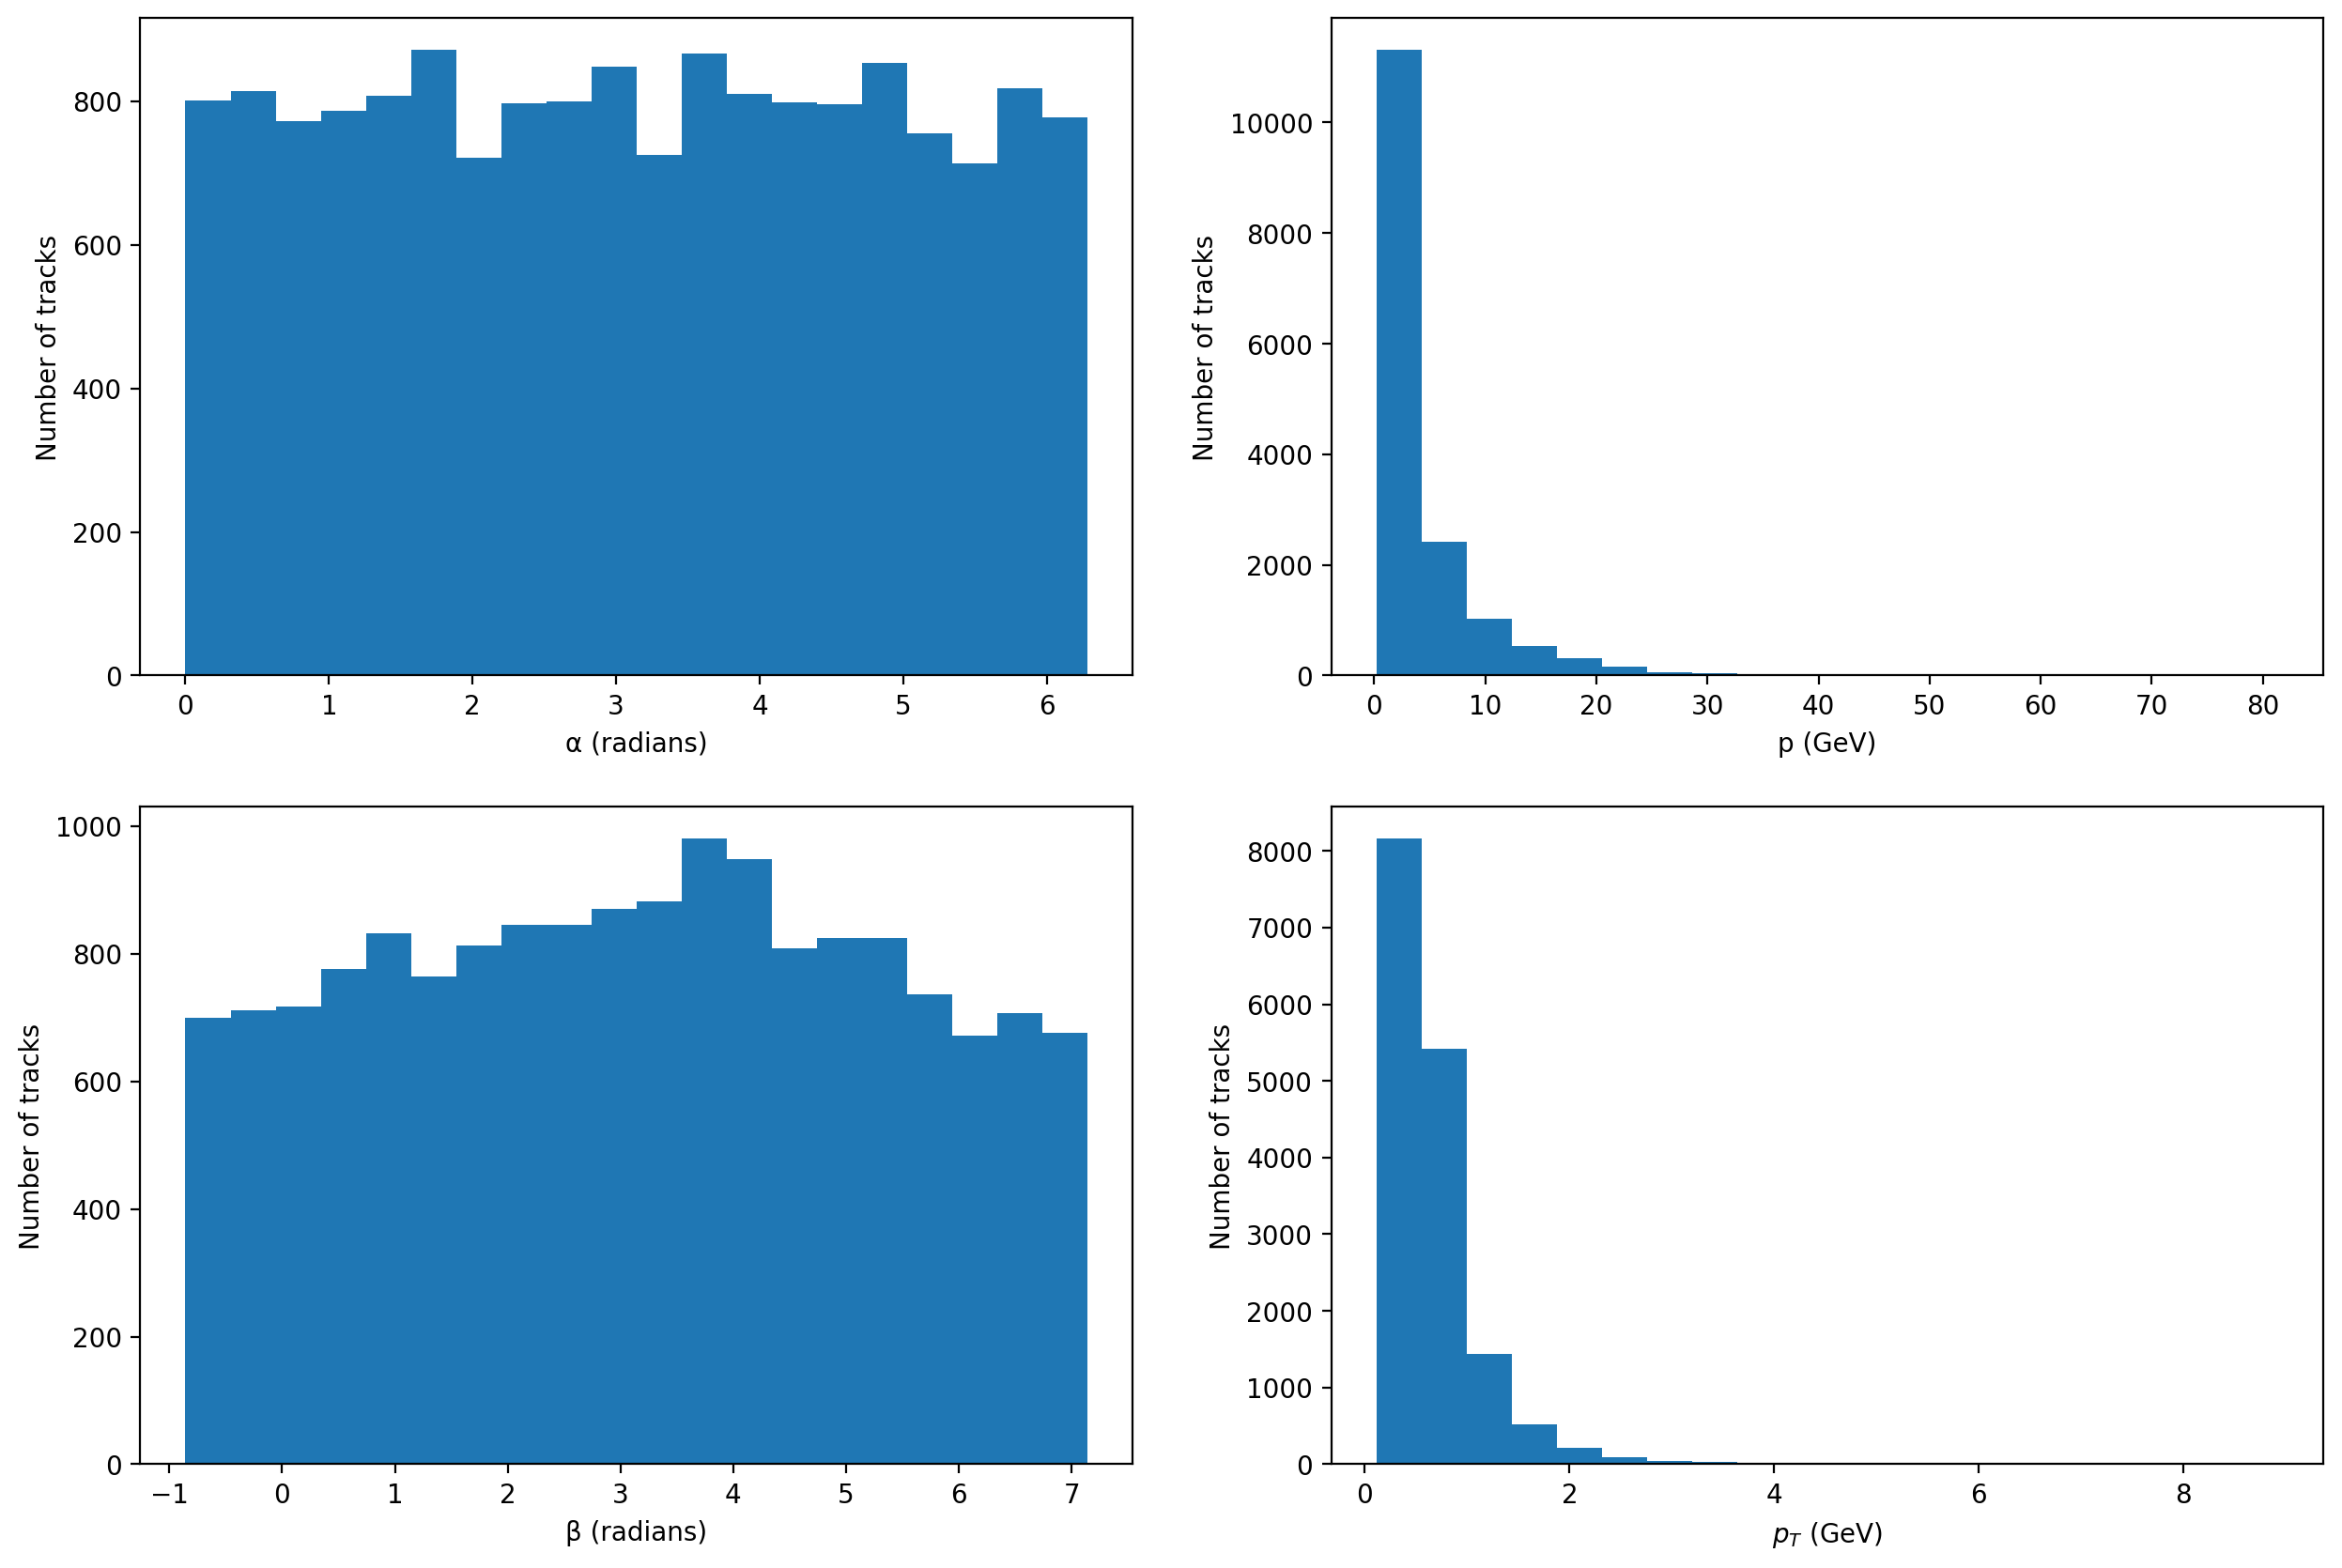

In [4]:
fig, ax = plt.subplots(2,2, figsize=(15,10),dpi=200)
ax[0][0].hist(alpha,bins=20,histtype='stepfilled');
ax[0][0].set_xlabel('\u03B1 (radians)')
ax[0][0].set_ylabel('Number of tracks')
ax[1][0].hist(beta,bins=20,histtype='stepfilled');
ax[1][0].set_xlabel('\u03B2 (radians)')
ax[1][0].set_ylabel('Number of tracks')
ax[0][1].hist(p,bins=20,histtype='stepfilled');
ax[0][1].set_xlabel('p (GeV)')
ax[0][1].set_ylabel('Number of tracks')
ax[1][1].hist(pT,bins=20,histtype='stepfilled');
ax[1][1].set_xlabel(r'$p_T$ (GeV)')
ax[1][1].set_ylabel('Number of tracks')
plt.show()

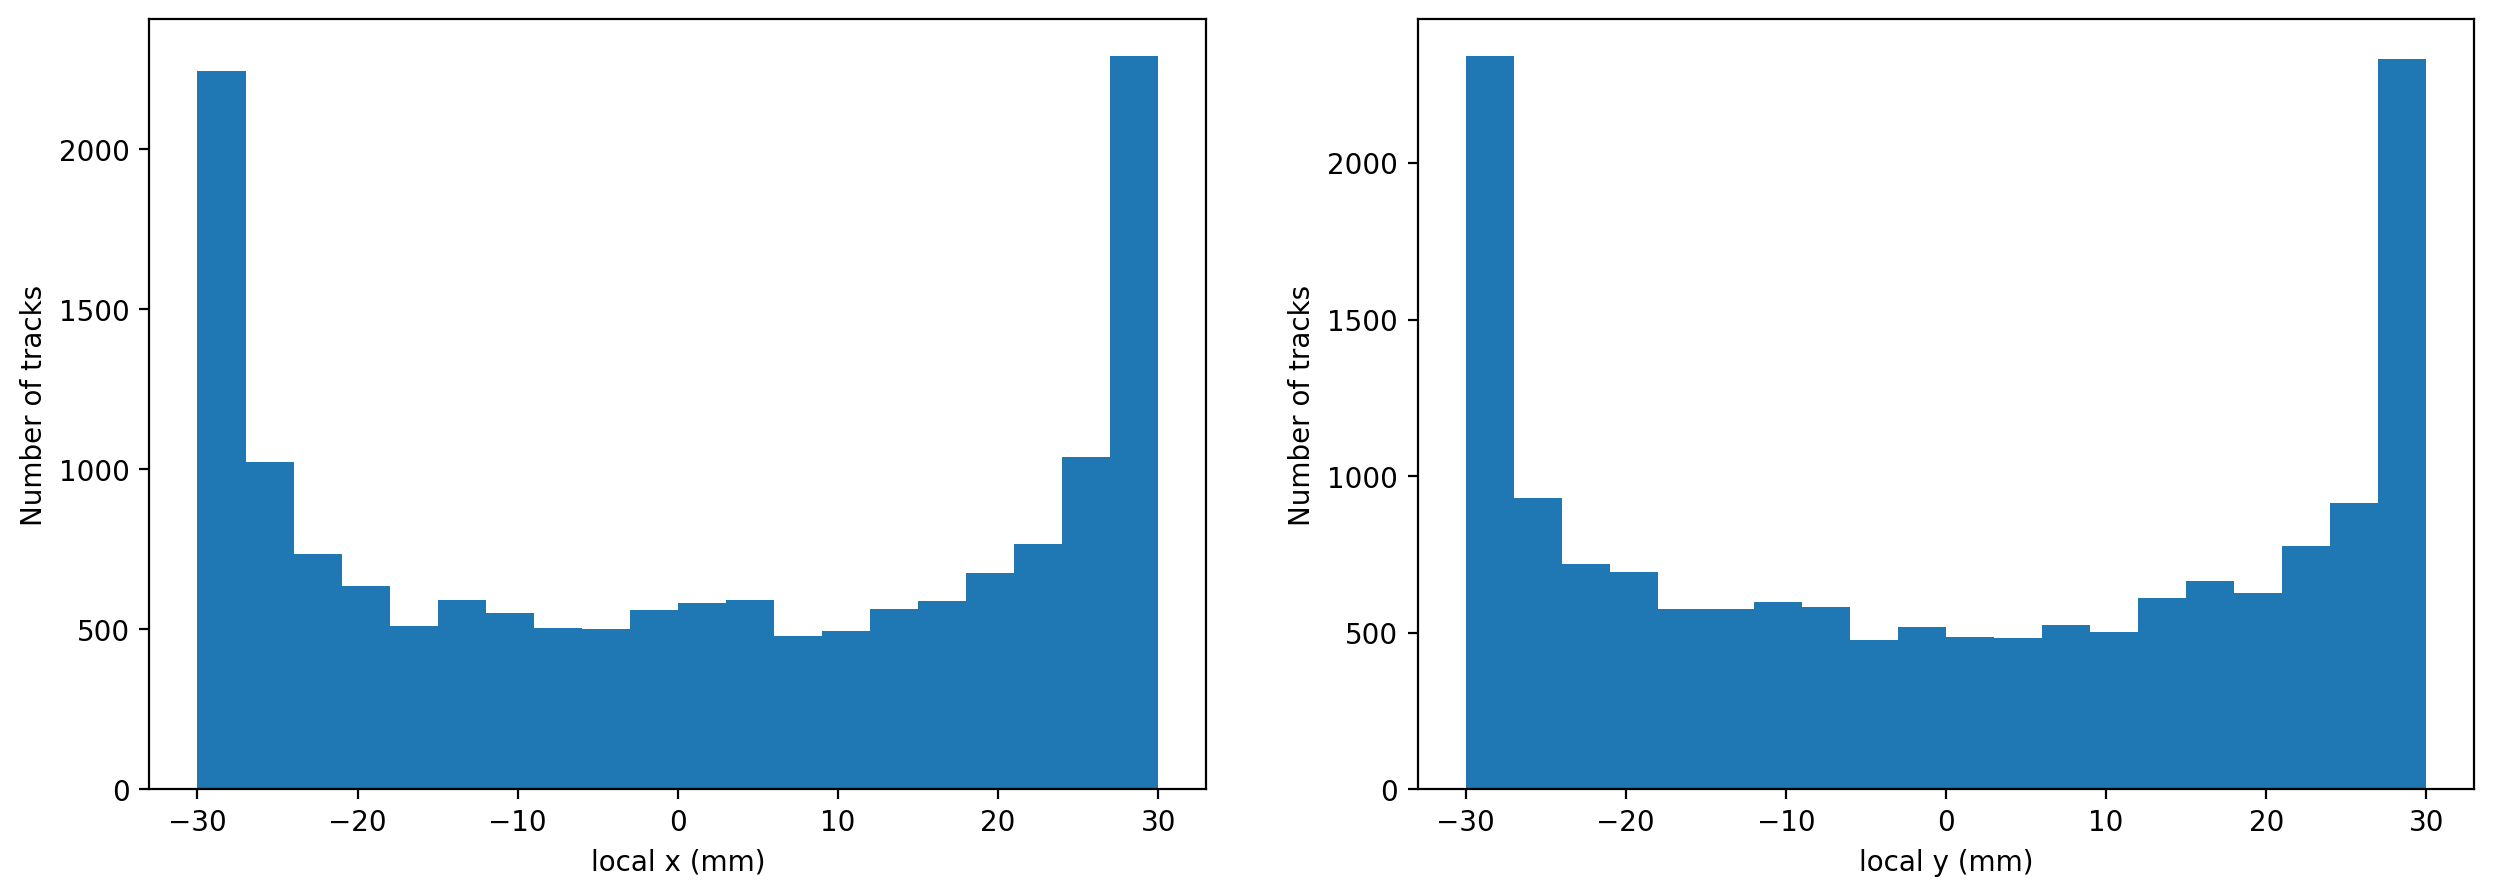

In [5]:
fig, ax = plt.subplots(1,2, figsize=(15,5),dpi=200)
ax[0].hist(localx,bins=20,histtype='stepfilled');
ax[0].set_xlabel('local x (mm)')
ax[0].set_ylabel('Number of tracks')
ax[1].hist(localy,bins=20,histtype='stepfilled');
ax[1].set_xlabel('local y (mm)')
ax[1].set_ylabel('Number of tracks')
plt.show()

Now look at a single pair of label parquet and root files:

In [9]:
tag = "_0.40_0.50_GeV"
parquetfile = f"{files}labels{tag}.parquet"
rootfile = f"{files}minbias{tag}.root"

In [10]:
truth = pd.read_parquet(parquetfile)
ylocal2 = truth['y-local'].to_numpy()

alpha, beta, p, localx, localy, pT = getDataFromRootFile(rootfile)
ylocal1 = np.array(localy)

In [11]:
from tabulate import tabulate
print(tabulate([['Delphes', len(ylocal1), ylocal1.min(), ylocal1.max(), ylocal1.std(), ylocal1.mean()], ['PixelAv', len(ylocal2),ylocal2.min(), ylocal2.max(), ylocal2.std(), ylocal2.mean()]], headers=['', "# of entries", 'Min', "Max", "Stdev", "Mean"], tablefmt='orgtbl'))

|         |   # of entries |      Min |     Max |   Stdev |     Mean |
|---------+----------------+----------+---------+---------+----------|
| Delphes |            679 | -29.9994 | 29.9998 | 21.4924 | 0.825098 |
| PixelAv |            739 | -30      | 29.9998 | 22.1024 | 0.755918 |
